In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load dataset
df = pd.read_csv("amazon.csv")

# Display basic dataset info
print("Dataset Overview:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Overview:
                                           reviewText  Positive
0  This is a one of the best apps acording to a b...         1
1  This is a pretty good version of the game for ...         1
2  this is a really cool game. there are a bunch ...         1
3  This is a silly game and can be frustrating, b...         1
4  This is a terrific game on any pad. Hrs of fun...         1

Missing Values:
 reviewText    0
Positive      0
dtype: int64


In [3]:
# Drop missing values
df.dropna(inplace=True)

In [4]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub("\d+", "", text)  # Remove numbers
    return text

df["cleaned_text"] = df["reviewText"].apply(preprocess_text)

In [5]:
# Splitting dataset
X = df["cleaned_text"]
y = df["Positive"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
# Model Selection and Training
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "Naïve Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }



In [8]:
# Hyperparameter Tuning for SVM
param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
svm_grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
best_svm = svm_grid.best_estimator_

y_pred_svm = best_svm.predict(X_test_tfidf)
results["Tuned SVM"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1 Score": f1_score(y_test, y_pred_svm),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_svm)
}


In [13]:
# LSTM Model
max_words = 5000  # Vocabulary size
max_len = 500  # Maximum sequence length

# Tokenization and padding
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),  # Ensure input_dim is set correctly
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Predictions
lstm_pred = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Evaluate model
results["LSTM"] = {
    "Accuracy": accuracy_score(y_test, lstm_pred),
    "Precision": precision_score(y_test, lstm_pred),
    "Recall": recall_score(y_test, lstm_pred),
    "F1 Score": f1_score(y_test, lstm_pred),
    "Confusion Matrix": confusion_matrix(y_test, lstm_pred)
}


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 286ms/step - accuracy: 0.7470 - loss: 0.5666 - val_accuracy: 0.7605 - val_loss: 0.5505
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 153s 307ms/step - accuracy: 0.7674 - loss: 0.5433 - val_accuracy: 0.7605 - val_loss: 0.5527
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - accuracy: 0.7530 - loss: 0.5609 - val_accuracy: 0.7605 - val_loss: 0.5514
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 163s 326ms/step - accuracy: 0.7636 - loss: 0.5476 - val_accuracy: 0.7605 - val_loss: 0.5505
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 265ms/step - accuracy: 0.7597 - loss: 0.5516 - val_accuracy: 0.7605 - val_loss: 0.5505
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step


In [15]:
# Comparative Analysis
for model, metrics in results.items():
    print(f"\n{model} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    


Logistic Regression Performance:
Accuracy: 0.89
Precision: 0.8973732437385461
Recall: 0.9658119658119658
F1 Score: 0.9303356554781508
Confusion Matrix: [[ 622  336]
 [ 104 2938]]

Random Forest Performance:
Accuracy: 0.872
Precision: 0.8861416361416361
Recall: 0.9543063773833005
F1 Score: 0.9189616967394745
Confusion Matrix: [[ 585  373]
 [ 139 2903]]

SVM Performance:
Accuracy: 0.8925
Precision: 0.9006134969325154
Recall: 0.965154503616042
F1 Score: 0.9317676927959379
Confusion Matrix: [[ 634  324]
 [ 106 2936]]

Naïve Bayes Performance:
Accuracy: 0.85975
Precision: 0.8545298656759074
Recall: 0.9829059829059829
F1 Score: 0.9142332976609081
Confusion Matrix: [[ 449  509]
 [  52 2990]]

Gradient Boosting Performance:
Accuracy: 0.838
Precision: 0.8345444382336501
Recall: 0.9815910585141354
F1 Score: 0.9021148036253777
Confusion Matrix: [[ 366  592]
 [  56 2986]]

Tuned SVM Performance:
Accuracy: 0.893
Precision: 0.907165109034268
Recall: 0.9572649572649573
F1 Score: 0.9315419065898913
C

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


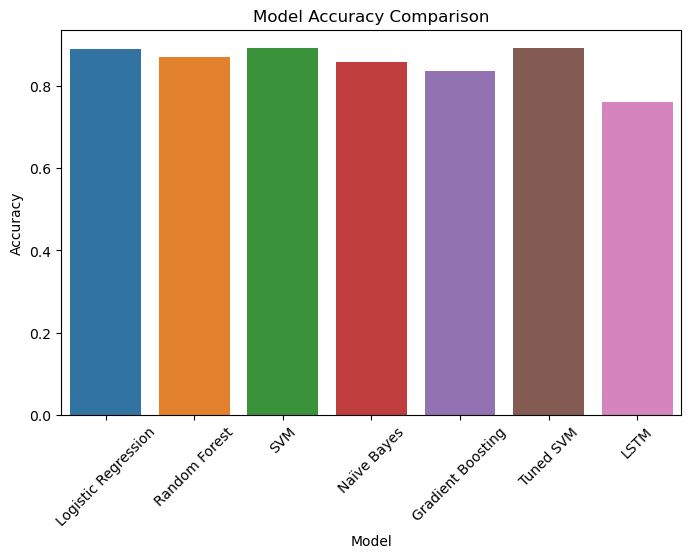


Conclusion: The best-performing model is determined based on the highest accuracy and other metric values.


In [17]:
# Plot Accuracy Comparison
plt.figure(figsize=(8,5))
model_names = list(results.keys())
accuracies = [results[m]["Accuracy"] for m in model_names]
sns.barplot(x=model_names, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

print("\nConclusion: The best-performing model is determined based on the highest accuracy and other metric values.")
